<a href="https://colab.research.google.com/github/Clarke-Jools-36/diss-gw/blob/main/autoencoder_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I am going to attempt to set up a simple autoencoder. First I need to create data on which to test and train the autoencoder. I will create gravitational wave sections 1 second long with 1024 samples. 
I will also create artefacts which are not gravitational waves. 

In [60]:
import numpy as np

from matplotlib import pyplot as plt

Lets import our training data

In [61]:
x_train = np.load("Diss/test_blip_data.npz")["blip_train"]
t_train = np.tile( np.arange(0, len(x_train[1]), 1) , (len(x_train),1) )

x_test = np.load("Diss/test_blip_data.npz")["blip_test"]
t_test = np.tile( np.arange(0, len(x_test[1]), 1) , (len(x_test),1) )

Time to start thinking about the autoencoder

In [62]:
"""import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(1024,)) 
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(1024, activation='sigmoid')(encoded)  
# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)"""

'import keras\nfrom keras import layers\n\n# This is the size of our encoded representations\nencoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats\n\n# This is our input image\ninput_img = keras.Input(shape=(1024,)) \n# "encoded" is the encoded representation of the input\nencoded = layers.Dense(encoding_dim, activation=\'relu\')(input_img)\n# "decoded" is the lossy reconstruction of the input\ndecoded = layers.Dense(1024, activation=\'sigmoid\')(encoded)  \n# This model maps an input to its reconstruction\nautoencoder = keras.Model(input_img, decoded)'

This is a non sequential example, lets use a sequential lstm example instead

In [63]:
import keras
from keras import models
from keras.layers import Dense, LSTM

encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

autoencoder = models.Sequential()
autoencoder.add(Dense(encoding_dim, activation='relu', input_shape=(1024,)))
autoencoder.add(Dense(1024, activation='sigmoid'))

# Compile model
autoencoder.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Now we create an encoder model

In [64]:
# This model maps an input to its encoded representation
#encoder = keras.Model(input_img, encoded)

and a decoder model

In [65]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

In [66]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                32800     
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              33792     
Total params: 66,592
Trainable params: 66,592
Non-trainable params: 0
_________________________________________________________________


In [67]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
print(x_test.shape)

(90000, 1024)
(10000, 1024)


now lets train for 50 epochs

In [68]:
autoencoder.fit(t_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(t_test, x_test))

Epoch 1/50
352/352 [==============================] - 2s 3ms/step - loss: 0.7411 - val_loss: 0.5409
Epoch 2/50
352/352 [==============================] - 1s 3ms/step - loss: 0.4796 - val_loss: 0.4233
Epoch 3/50
352/352 [==============================] - 1s 3ms/step - loss: 0.3770 - val_loss: 0.3345
Epoch 4/50
352/352 [==============================] - 1s 3ms/step - loss: 0.2994 - val_loss: 0.2671
Epoch 5/50
352/352 [==============================] - 1s 3ms/step - loss: 0.2403 - val_loss: 0.2155
Epoch 6/50
352/352 [==============================] - 1s 3ms/step - loss: 0.1948 - val_loss: 0.1756
Epoch 7/50
352/352 [==============================] - 1s 3ms/step - loss: 0.1593 - val_loss: 0.1442
Epoch 8/50
352/352 [==============================] - 1s 3ms/step - loss: 0.1314 - val_loss: 0.1194
Epoch 9/50
352/352 [==============================] - 1s 3ms/step - loss: 0.1091 - val_loss: 0.0995
Epoch 10/50
352/352 [==============================] - 1s 3ms/step - loss: 0.0912 - val_loss: 0.0834

lets visualise

In [74]:
# Encode and decode some digits
# Note that we take them from the *test* set

decoded_imgs = autoencoder.predict(x_test)

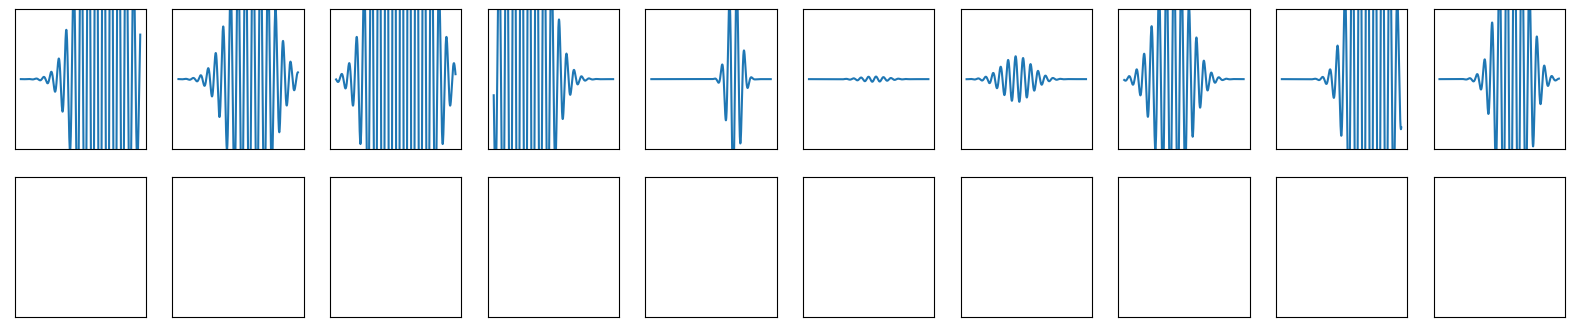

In [76]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt
y_range = 0.0001
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.plot(x_test[i])
    plt.ylim(-y_range,y_range)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(decoded_imgs[i])
    plt.ylim(-y_range,y_range)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()